In [1]:
!pip install neuron

In [2]:
# import packages
from neuron import h
from neuron.units import um, mV, ms, cm
h.load_file('stdrun.hoc')

1.0

In [3]:
import matplotlib.pyplot as plt
import plotly

In [69]:
def Reset():
  for sec in h.allsec():
    h.delete_section(sec = sec)

In [179]:
# function to reset the clamp
Reset()
axon = h.Section(name = 'axon')
axon.L = 1*cm # Length of the axom. This is very long axon.
axon.diam = 1*um # Diamter of the axon
axon.nseg = 1001 # Split the axon into 1001 segments
# Initialize ion channels using Hodgekin Huxley model
h.hh.insert(axon)
# Initialize Voltage Clamp to stimulate neuron
iclamp = h.IClamp(axon(0))
iclamp.delay = 5
iclamp.dur = 0.1
iclamp.amp = 0.9

In [187]:
# function to reset the clamp
Reset()
axon = h.Section(name = 'axon')
axon.L = 1*cm # Length of the axom. This is very long axon.
axon.diam = 1*um # Diamter of the axon
axon.nseg = 1001 # Split the axon into 1001 segments
# Initialize ion channels using Hodgekin Huxley model
h.hh.insert(axon)
# Initialize Voltage Clamp to stimulate neuron
vclamp = h.VClamp(axon(0))
vclamp.dur[0], vclamp.dur[1], vclamp.dur[2] = [5, 2, 0]
vclamp.amp[0], vclamp.amp[1], vclamp.amp[2] = [-65, -50, 0]

In [188]:
rvp = h.RangeVarPlot('v', axon(0), axon(1))

In [189]:
h.topology()


|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

1.0

In [190]:
# function to plot action potential propagation along axon
def PlotAxonRangeVarPlot(ax):
  h.finitialize(-65*mV) # Initialize at -65 millivolts
  # fig, ax = plt.subplots(1)
  for tstop in range(5, 25, 2):
    h.continuerun(tstop)
    rvp.plot(ax, label = f'{tstop} ms')

  ax.set_title(f'Resistance = {axon.Ra} ohms, Diameter = {axon.diam} um')
  ax.set_xlabel('Distance from start of axon (um)')
  ax.set_ylabel('Voltage (mV)')

  # plt.show()

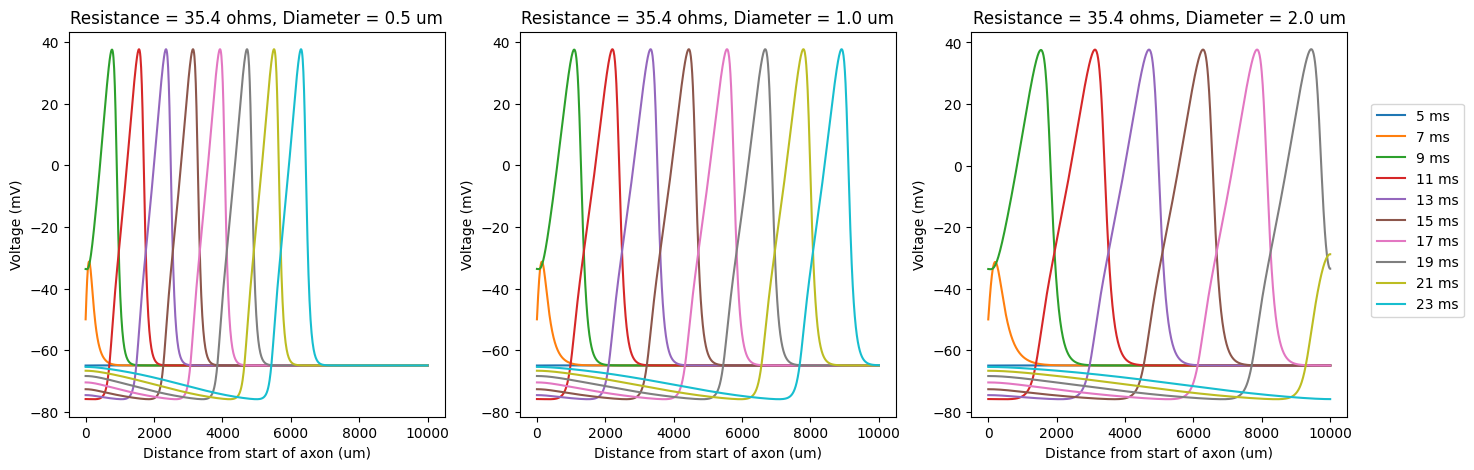

In [191]:
# plot many subplots of action potential propagation along axon (varying resitance and/or diameter of axon)
fig, ax = plt.subplots(1,3)
fig.set_size_inches(16.5, 5)

for i, diam in [(0, 0.5*um),(1, 1*um),(2, 2*um)]:
  axon.diam = diam
  PlotAxonRangeVarPlot(ax[i])

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles = handles ,bbox_to_anchor = (0.975, 0.75))
axon.diam = 1*um

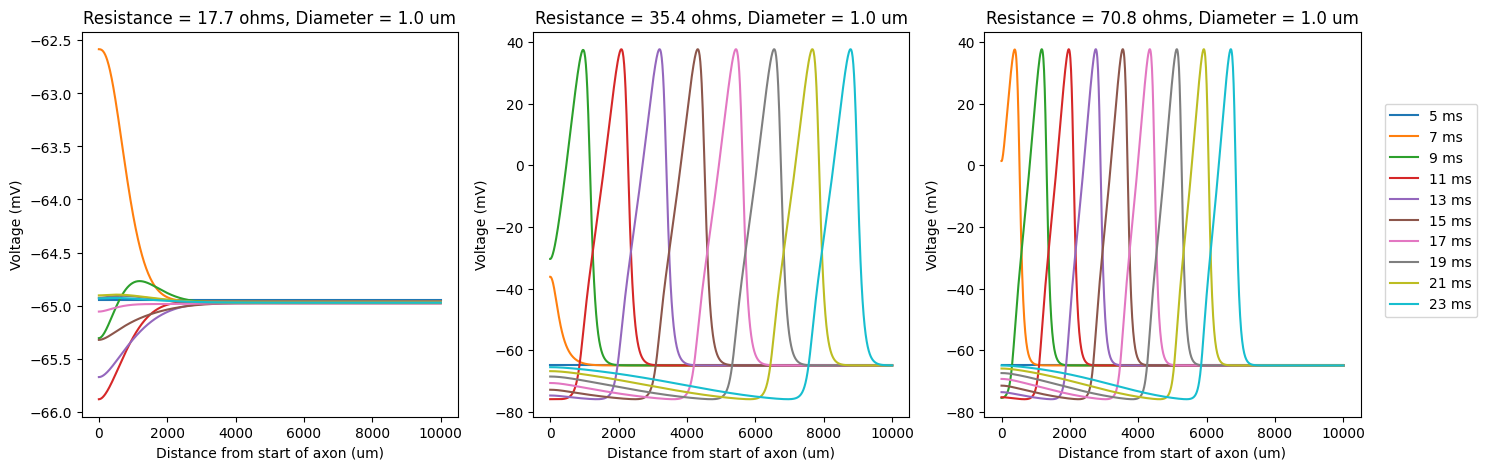

In [29]:
# plot many subplots of action potential propagation along axon (varying resitance and/or diameter of axon)
fig, ax = plt.subplots(1,3)
fig.set_size_inches(16.5, 5)

for i, ra in [(0, 35.4/2),(1, 35.4),(2, 2*35.4)]:
  axon.Ra = ra
  PlotAxonRangeVarPlot(ax[i])

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles = handles ,bbox_to_anchor = (0.975, 0.75))
axon.Ra = 35.4

In [ ]:
ps = h.PlotShape(False)
ps.variable('v')
ps.scale(-65, 30)
ps.plot(plotly)

In [172]:
# bipolar neuron class setup
class BipolarNeuron():
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    # morphology (neuron components and shapes and sizes)
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.axon = h.Section(name='axon', cell=self)
        self.all = [self.soma, self.dend, self.axon]
        # self.all = [self.soma, self.dend]
        self.soma.connect(self.dend(1))
        self.axon.connect(self.soma(1))
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
        self.axon.L = 400
        self.axon.diam = 1
    # sets up neuron's biophysics (channel conductances... etc)
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert('pas')
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65    # Leak reversal potential mV
        # Insert Hodgekin-Huxley for axon
        self.axon.insert('hh')
        for seg in self.axon:
          seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
          seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
          seg.hh.gl = 0.0003    # Leak conductance in S/cm2
          seg.hh.el = -54.3     # Reversal potential in mV
    def __repr__(self):
        return 'BipolarNeuron[{}]'.format(self._gid)


In [173]:
for sec in h.allsec():
    print('%s: %s' % (sec, ', '.join(sec.psection()['density_mechs'].keys())))

BipolarNeuron[0].soma: hh
BipolarNeuron[0].dend: pas
BipolarNeuron[0].axon: hh


In [205]:
Reset()
# show bipolar neuron illustrations
my_cell = BipolarNeuron(0)
my_cell.axon.v = 50
my_cell.soma.v = 0
my_cell.dend.v = -50
ps = h.PlotShape(False)
ps.variable('v')
ps.scale(-50, 50)
fig = ps.plot(plotly)
fig.update_traces(line=dict(width=15))
fig.update_layout(title_text="Bipolar Neuron", title_x=0.5)
fig.show()

In [61]:
stim_duration = 2
stim_amp = 0.1

In [72]:
# initialize system stimulus
def InitSystem(nseg = 1, delay = 5, duration = 2, current = 0.1):
  Reset()
  my_cell = BipolarNeuron(0)

  for sec in my_cell.all:
    sec.nseg = nseg

  stim = h.IClamp(my_cell.dend(0))
  stim.delay = delay
  stim.dur = duration
  stim.amp = current
  return my_cell, stim


Text(0.5, 1.0, 'Stimulus Duration 2.0 ms, Current 0.1')

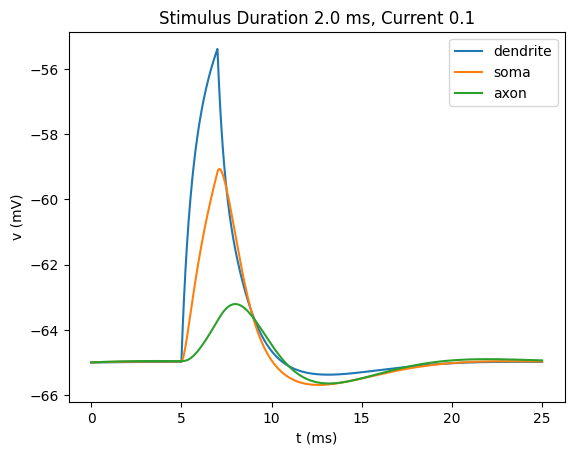

In [73]:
# plot for neuron components' membrane potentials for 2.0 ms stimulus
my_cell, stim = InitSystem()
dend_v = h.Vector().record(my_cell.dend(0.5)._ref_v)
soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
axon_v = h.Vector().record(my_cell.axon(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-65 * mV)
h.continuerun(25 * ms)

fig, ax = plt.subplots(1)
ax.plot(t, dend_v, label = 'dendrite')
ax.plot(t, soma_v, label = 'soma')
ax.plot(t, axon_v, label = 'axon')
ax.set_xlabel('t (ms)')
ax.set_ylabel('v (mV)')
ax.legend()
ax.set_title(f'Stimulus Duration {stim.dur} ms, Current {stim.amp}')


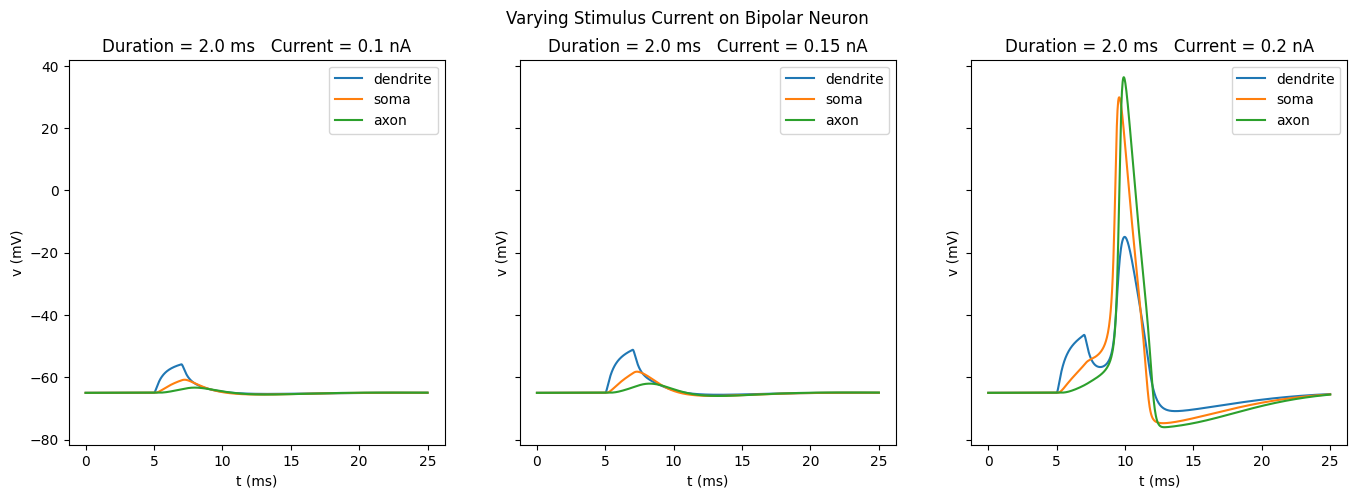

In [219]:
# bipolar neuron plots (membrane potentials vs time for different stimuli settings)
fig, ax = plt.subplots(1,3, sharey = True)
fig.set_size_inches(16.5, 5)
for i, amp in [(0, 0.1),(1, 0.15),(2, 0.2)]:
  my_cell, stim = InitSystem(nseg = 1001, current = amp)
  dend_v = h.Vector().record(my_cell.dend(0.5)._ref_v)
  soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
  axon_v = h.Vector().record(my_cell.axon(0.5)._ref_v)
  t = h.Vector().record(h._ref_t)
  h.finitialize(-65 * mV)
  h.continuerun(25 * ms)
  ax[i].plot(t, dend_v, label = 'dendrite')
  ax[i].plot(t, soma_v, label = 'soma')
  ax[i].plot(t, axon_v, label = 'axon')
  ax[i].set_xlabel('t (ms)')
  ax[i].set_ylabel('v (mV)')
  ax[i].legend()
  ax[i].set_title(f'Duration = {stim.dur} ms   Current = {stim.amp} nA')

fig.suptitle('Varying Stimulus Current on Bipolar Neuron')

plt.show()

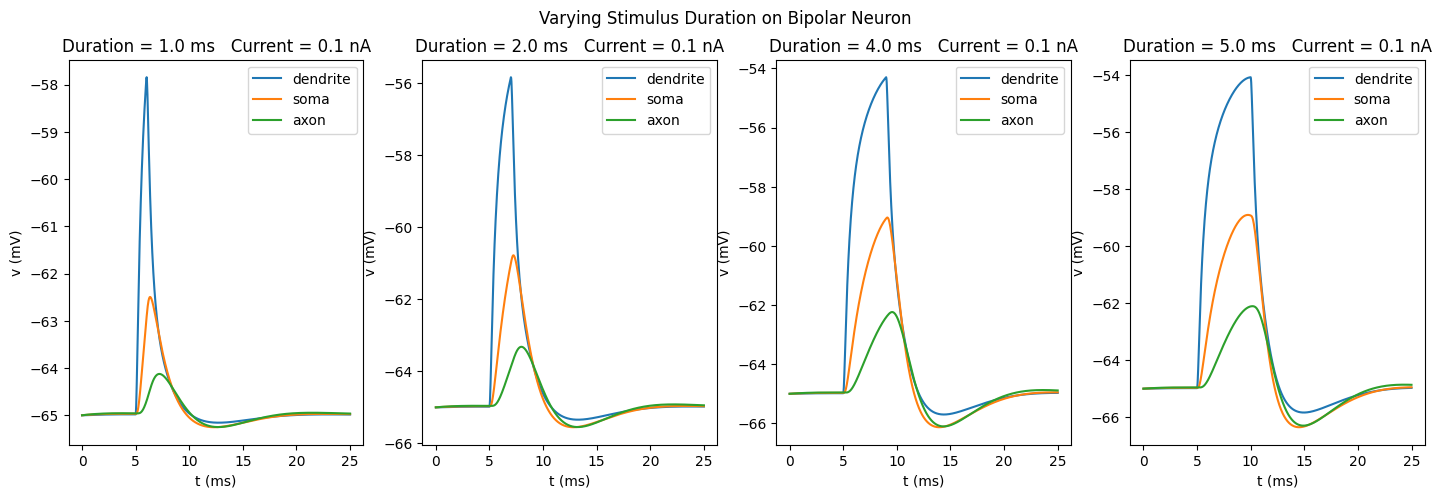

In [220]:
# bipolar neuron plots (membrane potentials vs time for different stimuli settings)
fig, ax = plt.subplots(1,4)
fig.set_size_inches(17.5, 5)
for i, dur in [(0, 1),(1, 2),(2, 4), (3,5)]:
  my_cell, stim = InitSystem(nseg = 1001, duration = dur)
  dend_v = h.Vector().record(my_cell.dend(0.5)._ref_v)
  soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
  axon_v = h.Vector().record(my_cell.axon(0.5)._ref_v)
  t = h.Vector().record(h._ref_t)
  h.finitialize(-65 * mV)
  h.continuerun(25 * ms)
  ax[i].plot(t, dend_v, label = 'dendrite')
  ax[i].plot(t, soma_v, label = 'soma')
  ax[i].plot(t, axon_v, label = 'axon')
  ax[i].set_xlabel('t (ms)')
  ax[i].set_ylabel('v (mV)')
  ax[i].legend()
  ax[i].set_title(f'Duration = {stim.dur} ms   Current = {stim.amp} nA')

fig.suptitle('Varying Stimulus Duration on Bipolar Neuron')

plt.show()

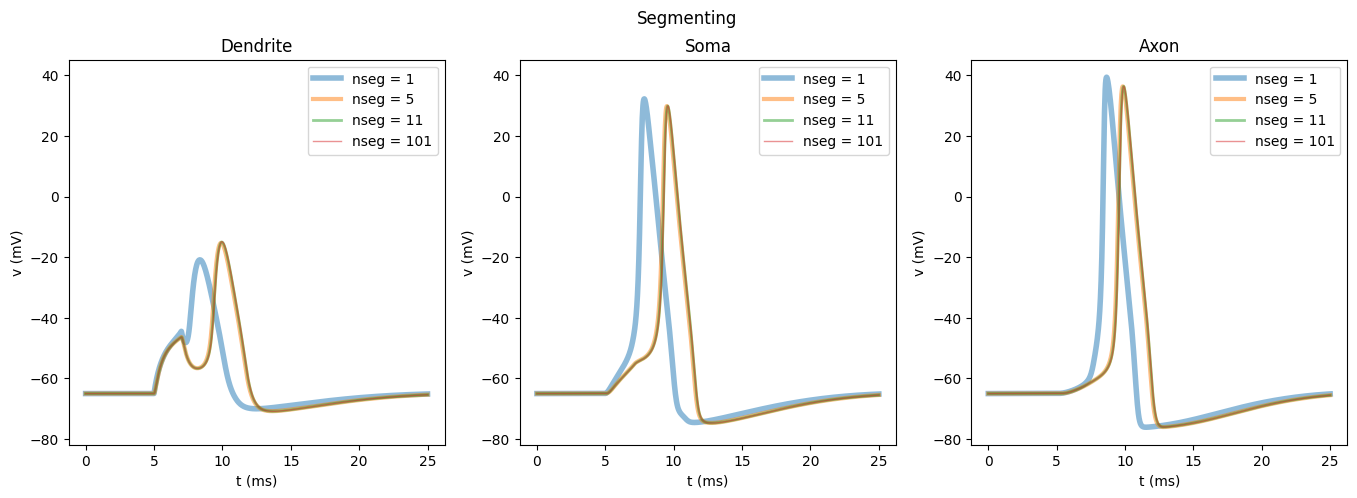

In [218]:
# segmenting subplots for axon components
fig, ax = plt.subplots(1,3)
fig.set_size_inches(16.5, 5)
fig.suptitle('Segmenting')
for nseg, linewidth in [(1, 4), (5, 3), (11, 2), (101, 1)]:
  my_cell, stim = InitSystem(nseg = nseg, current = 0.2)
  dend_v = h.Vector().record(my_cell.dend(0.5)._ref_v)
  soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
  axon_v = h.Vector().record(my_cell.axon(0.5)._ref_v)
  t = h.Vector().record(h._ref_t)
  h.finitialize(-65 * mV)
  h.continuerun(25*ms)
  ax[0].plot(t, dend_v, label = f'nseg = {nseg}', linewidth = linewidth, linestyle = '-', alpha = 0.5)
  ax[1].plot(t, soma_v, label = f'nseg = {nseg}', linewidth = linewidth, linestyle = '-', alpha = 0.5)
  ax[2].plot(t, axon_v, label = f'nseg = {nseg}', linewidth = linewidth, linestyle = '-', alpha = 0.5)

ax[0].set_xlabel('t (ms)')
ax[0].set_ylabel('v (mV)')
ax[0].legend()
ax[0].set_title('Dendrite')

ax[1].set_xlabel('t (ms)')
ax[1].set_ylabel('v (mV)')
ax[1].sharey(ax[0])
ax[1].legend()
ax[1].set_title('Soma')

ax[2].set_xlabel('t (ms)')
ax[2].set_ylabel('v (mV)')
ax[2].sharey(ax[0])
ax[2].legend()
ax[2].set_title('Axon')
plt.show()

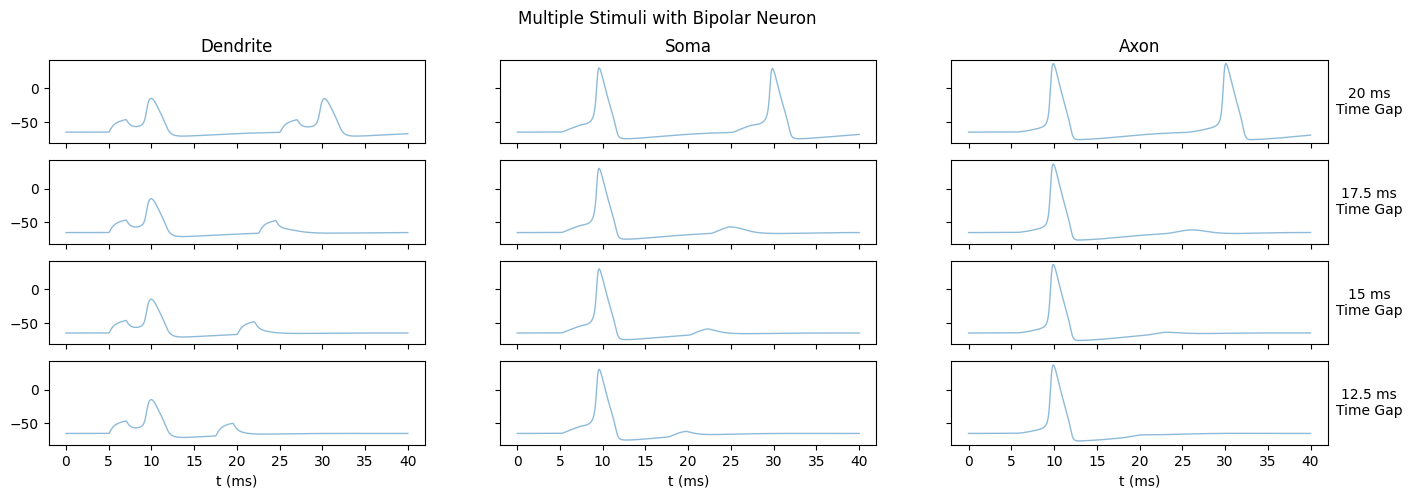

In [169]:
# neuron component subplots for bipolar neurons
fig, ax = plt.subplots(4,3, squeeze = False, sharex = True, sharey = True)
fig.set_size_inches(16.5, 5)
fig.suptitle('Multiple Stimuli with Bipolar Neuron')
for i, delay, linewidth in [(0, 25, 1), (1, 22.5, 1), (2, 20, 1), (3, 17.5, 1)]:
  my_cell, stim = InitSystem(nseg = 1001, current = 0.2)
  stim2 = h.IClamp(my_cell.dend(0))
  stim2.delay = delay
  stim2.dur = 2
  stim2.amp = 0.2

  dend_v = h.Vector().record(my_cell.dend(0.5)._ref_v)
  soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
  axon_v = h.Vector().record(my_cell.axon(0.5)._ref_v)
  t = h.Vector().record(h._ref_t)
  h.finitialize(-65 * mV)
  h.continuerun(40*ms)
  ax[i, 0].plot(t, dend_v, label = f'Time Gap = {delay - 5} ms', linewidth = linewidth, linestyle = '-', alpha = 0.5)
  ax[i, 1].plot(t, soma_v, label = f'Time Gap = {delay - 5} ms', linewidth = linewidth, linestyle = '-', alpha = 0.5)
  ax[i, 2].plot(t, axon_v, label = f'Time Gap = {delay - 5} ms', linewidth = linewidth, linestyle = '-', alpha = 0.5)

  bbox_loc = ax[i,0].get_position().get_points()
  fig.text(0.925, 0.5*sum(bbox_loc[:, 1]), f'{delay - 5} ms\nTime Gap', ha='center', va='center', rotation='horizontal')


ax[-1,0].set_xlabel('t (ms)')
ax[0,0].set_title('Dendrite')

ax[-1,1].set_xlabel('t (ms)')
ax[0,1].set_title('Soma')

ax[-1,2].set_xlabel('t (ms)')
ax[0,2].set_title('Axon')

plt.show()

In [163]:
# set up the multipolar neuron class
class MultiPolarNueron():
    def __init__(self, gid, num_dendrites = 4):
        self._gid = gid
        self._setup_morphology(num_dendrites= num_dendrites)
        self._setup_biophysics()
    def _setup_morphology(self, num_dendrites=4):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = [h.Section(name=f'dend{i}', cell=self) for i in range(num_dendrites)]
        self.axon = h.Section(name='axon', cell=self)
        self.all = [self.soma, self.dend, self.axon]
        for dend in self.dend:
          dend.connect(self.soma(0), 1)
        self.axon.connect(self.soma(1))
        self.soma.L = self.soma.diam = 12.6157
        for dend in self.dend:
          dend.L = 200
          dend.diam = 1
        self.axon.L = 400
        self.axon.diam = 1
    def _setup_biophysics(self):
        for sec in self.all:
            if type(sec) == list:
              for s in sec:
                s.Ra = 100    # Axial resistance in Ohm * cm
                s.cm = 1      # Membrane capacitance in micro Farads / cm^2
            else:
              sec.Ra = 100    # Axial resistance in Ohm * cm
              sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite
        for dend in self.dend:
            dend.insert('pas')
            for seg in dend:
              seg.pas.g = 0.001  # Passive conductance in S/cm2
              seg.pas.e = -65    # Leak reversal potential mV
        # Insert Hodgekin-Huxley for axon
        self.axon.insert('hh')
        for seg in self.axon:
          seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
          seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
          seg.hh.gl = 0.0003    # Leak conductance in S/cm2
          seg.hh.el = -54.3     # Reversal potential in mV
    def __repr__(self):
        return 'MultiPolarNeuron[{}]'.format(self._gid)

In [206]:
Reset()
# set up the cell and multipolar neuron
my_cell = MultiPolarNueron('0', 10)
h.topology()


|-|       MultiPolarNeuron[0].soma(0-1)
   `|       MultiPolarNeuron[0].axon(0-1)
 `|       MultiPolarNeuron[0].dend0(1-0)
 `|       MultiPolarNeuron[0].dend1(1-0)
 `|       MultiPolarNeuron[0].dend2(1-0)
 `|       MultiPolarNeuron[0].dend3(1-0)
 `|       MultiPolarNeuron[0].dend4(1-0)
 `|       MultiPolarNeuron[0].dend5(1-0)
 `|       MultiPolarNeuron[0].dend6(1-0)
 `|       MultiPolarNeuron[0].dend7(1-0)
 `|       MultiPolarNeuron[0].dend8(1-0)
 `|       MultiPolarNeuron[0].dend9(1-0)



1.0

In [207]:
# show layout of multipolar neuron
ps = h.PlotShape(False)
my_cell.axon.v = 50
my_cell.soma.v = 0
for dend in my_cell.dend:
  dend.v = -50
ps = h.PlotShape(False)
ps.variable('v')
ps.scale(-50, 50)
fig = ps.plot(plotly)
fig.update_traces(line=dict(width=15))
fig.update_layout(title_text="Multipolar Neuron", title_x=0.5)
fig.show()

In [129]:
# initialize multipolar neuron system and stimulus
def InitSystemMP(nseg = 1, delay = 5, duration = 2, current = 0.1):
  Reset()
  my_cell = MultiPolarNueron(0, 10)

  for sec in my_cell.all:
    if type(sec) == list:
      for s in sec:
        s.nseg = nseg
    else:
      sec.nseg = nseg

  stims = []
  for dend in my_cell.dend:
    stim = h.IClamp(dend(0))
    stim.delay = delay
    stim.dur = duration
    stim.amp = current
    stims.append(stim)
  return my_cell, stims

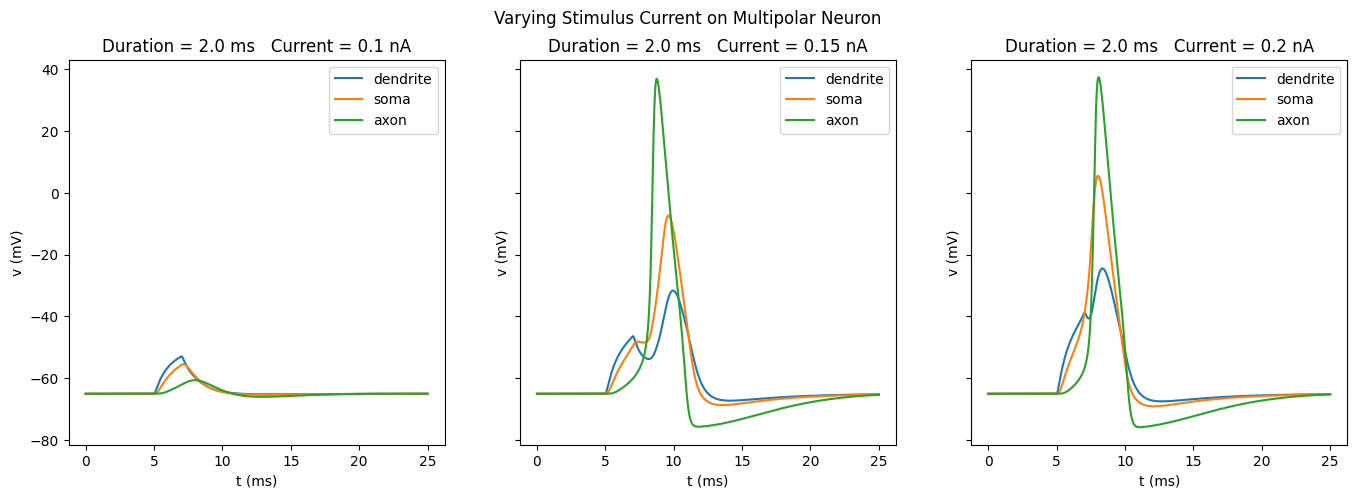

In [221]:
# subplots varying stimuli on multipolar neuron
fig, ax = plt.subplots(1,3, sharey = True)
fig.set_size_inches(16.5, 5)
for i, amp in [(0, 0.1),(1, 0.15),(2, 0.2)]:
  my_cell, stims = InitSystemMP(nseg = 1001, current = amp)
  dend_v = [h.Vector().record(dend(0.5)._ref_v) for dend in my_cell.dend]
  soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
  axon_v = h.Vector().record(my_cell.axon(0.5)._ref_v)
  t = h.Vector().record(h._ref_t)
  h.finitialize(-65 * mV)
  h.continuerun(25 * ms)
  ax[i].plot(t, dend_v[0], label = 'dendrite')
  ax[i].plot(t, soma_v, label = 'soma')
  ax[i].plot(t, axon_v, label = 'axon')
  ax[i].set_xlabel('t (ms)')
  ax[i].set_ylabel('v (mV)')
  ax[i].legend()
  ax[i].set_title(f'Duration = {stims[0].dur} ms   Current = {stims[0].amp} nA')

fig.suptitle(f'Varying Stimulus Current on Multipolar Neuron')

plt.show()

Text(0.5, 0.98, 'Varying Stimlus Duration on Multipolar Neuron')

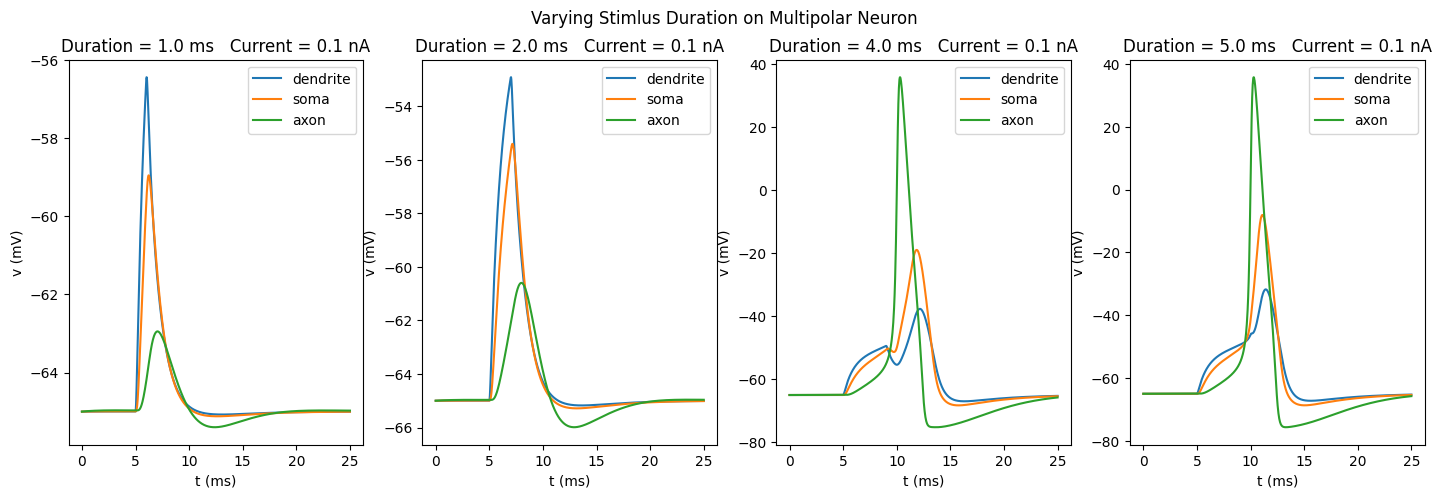

In [222]:
# subplots varying stimuli on multipolar neuron
fig, ax = plt.subplots(1,4)
fig.set_size_inches(17.5, 5)
for i, dur in [(0, 1),(1, 2),(2, 4), (3,5)]:
  my_cell, stims = InitSystemMP(nseg = 1001, duration = dur)
  dend_v = [h.Vector().record(dend(0.5)._ref_v) for dend in my_cell.dend]
  soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
  axon_v = h.Vector().record(my_cell.axon(0.5)._ref_v)
  t = h.Vector().record(h._ref_t)
  h.finitialize(-65 * mV)
  h.continuerun(25 * ms)
  ax[i].plot(t, dend_v[0], label = 'dendrite')
  ax[i].plot(t, soma_v, label = 'soma')
  ax[i].plot(t, axon_v, label = 'axon')
  ax[i].set_xlabel('t (ms)')
  ax[i].set_ylabel('v (mV)')
  ax[i].legend()
  ax[i].set_title(f'Duration = {stims[0].dur} ms   Current = {stims[0].amp} nA')

fig.suptitle(f'Varying Stimlus Duration on Multipolar Neuron')

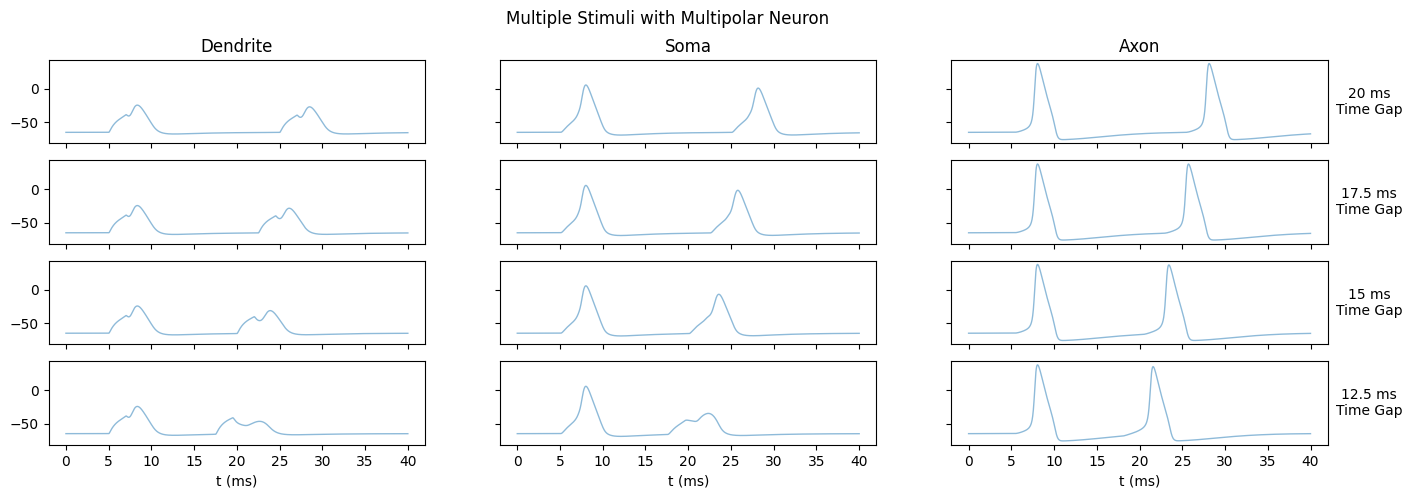

In [156]:
# subplots varying stimuli on multipolar neuron (by neuron components)
fig, ax = plt.subplots(4,3, squeeze = False, sharex = True, sharey = True)
fig.set_size_inches(16.5, 5)
fig.suptitle('Multiple Stimuli with Multipolar Neuron')
for i, delay, linewidth in [(0, 25, 1), (1, 22.5, 1), (2, 20, 1), (3, 17.5, 1)]:
  my_cell, stims = InitSystemMP(nseg = 1001, current = 0.2)
  stims2 = []
  for dend in my_cell.dend:
    stim = h.IClamp(dend(0))
    stim.delay = delay
    stim.dur = 2
    stim.amp = 0.2
    stims2.append(stim)

  dend_v = [h.Vector().record(dend(0.5)._ref_v) for dend in my_cell.dend]
  soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
  axon_v = h.Vector().record(my_cell.axon(0.5)._ref_v)
  t = h.Vector().record(h._ref_t)
  h.finitialize(-65 * mV)
  h.continuerun(40*ms)
  ax[i, 0].plot(t, dend_v[0], label = f'Time Gap = {delay - 5} ms', linewidth = linewidth, linestyle = '-', alpha = 0.5)
  ax[i, 1].plot(t, soma_v, label = f'Time Gap = {delay - 5} ms', linewidth = linewidth, linestyle = '-', alpha = 0.5)
  ax[i, 2].plot(t, axon_v, label = f'Time Gap = {delay - 5} ms', linewidth = linewidth, linestyle = '-', alpha = 0.5)

  bbox_loc = ax[i,0].get_position().get_points()
  fig.text(0.925, 0.5*sum(bbox_loc[:, 1]), f'{delay - 5} ms\nTime Gap', ha='center', va='center', rotation='horizontal')


ax[-1,0].set_xlabel('t (ms)')
ax[0,0].set_title('Dendrite')

ax[-1,1].set_xlabel('t (ms)')
ax[0,1].set_title('Soma')

ax[-1,2].set_xlabel('t (ms)')
ax[0,2].set_title('Axon')

plt.show()